# Business Problem

1. **Objective**
   - To classifiy a review on scale of 1 to 5, with 5 representing postive sentiment and 1 representing negative sentiment
   - Learn from reviews and thier properties to predict the sentiment


2. **Machine Learning Problem**
   - Develop a machine learning model based on gated recurrent neural network to learn properties on a scale of 1 to 5 and predict accurately for new review


3. **Technology**
   - Python, Scikit-learn, tensorflow, keras, Numpy
   

4. **Decision making**
   - Select the best model which performs the best w.r.t classification accuracy
   - Metrics: Accuracy
   

5. **Deployment**
   - Deploy model in a scalable way so that business decisions can be taken in near real time to predict sentiment of reviews



**Dataset**<br>
App reviews

In [5]:
!pip install nltk
!pip install pandas
!pip install tensorflow
!pip install textblob
!pip install Pillow
!pip install scikit-learn
!pip install matplotlib
!pip install wordcloud

  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import Word

In [4]:
df = pd.read_csv("Data/review_data.csv")[["content", "score"]]
print(df.shape)

(1500, 2)


In [5]:
df.head()

,content,score
0,Overall it's really an amazing app. I've been ...,4
1,Hey! Yes I gave a 5 star rating... coz I belie...,5
2,Canva used to be a good app! But recently I've...,1
3,"It's a brilliant app, but I have just one prob...",5
4,This was such a great app. I used to make BTS ...,4


In [6]:
stop_words = stopwords.words('english')

In [7]:
def cleaning(df_tmp, stop_words):
    df_tmp = df.copy(deep=True)
    df_tmp['content'] = df_tmp['content'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

    # Replacing the special characters
    df_tmp['content'] = df_tmp['content'].str.replace("[^0-9a-zA-Z\s]+", '')

    # Replacing the digits/numbers
    #df_tmp['content'] = df_tmp['content'].str.replace('d', '')

    # Removing stop words
    df_tmp['content'] = df_tmp['content'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

    # Lemmatization
    df_tmp['content'] = df_tmp['content'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df_tmp

In [8]:
top_words = 5000
input_length = 500

In [9]:
df_new = cleaning(df, stop_words)

/tmp/ipykernel_3047/1906649417.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tmp['content'] = df_tmp['content'].str.replace("[^0-9a-zA-Z\s]+", '')


In [10]:
df_new.head()

,content,score
0,overall really amazing app ive using past 5 ye...,4
1,hey yes gave 5 star rating coz believe deserve...,5
2,canva used good app recently ive facing issue ...,1
3,brilliant app one problem im editing post doub...,5
4,great app used make bts meme recent update im ...,4


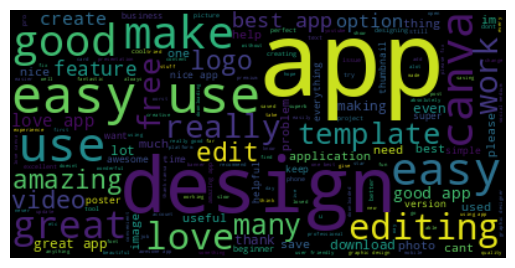

In [11]:
import wordcloud

common_words = ''
for i in df_new.content:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "

wordcloud = wordcloud.WordCloud().generate(common_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(df_new['content'].values)

X = tokenizer.texts_to_sequences(df['content'].values)
X = pad_sequences(X, input_length)

In [13]:
X.shape

(1500, 500)

In [14]:
#Splitting the data into training and testing
y = pd.get_dummies(df['score'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [24]:
model = Sequential()
model.add(Embedding(input_dim=top_words, output_dim=120))# input_length arg is depracated in keras version
model.add(SpatialDropout1D(0.2))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.build(input_shape=(None, X.shape[1]))
print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 500, 120)       │       600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 500, 120)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        35,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 636,037 (2.43 MB)

 Trainable params: 636,037 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
batch_size=32
epochs=5
history = model.fit(X_train, y_train, epochs = epochs, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 711ms/step - accuracy: 0.5373 - loss: 1.4395
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 653ms/step - accuracy: 0.6268 - loss: 0.9982
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 651ms/step - accuracy: 0.6311 - loss: 0.9340
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - accuracy: 0.7048 - loss: 0.7753
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 648ms/step - accuracy: 0.7248 - loss: 0.7368


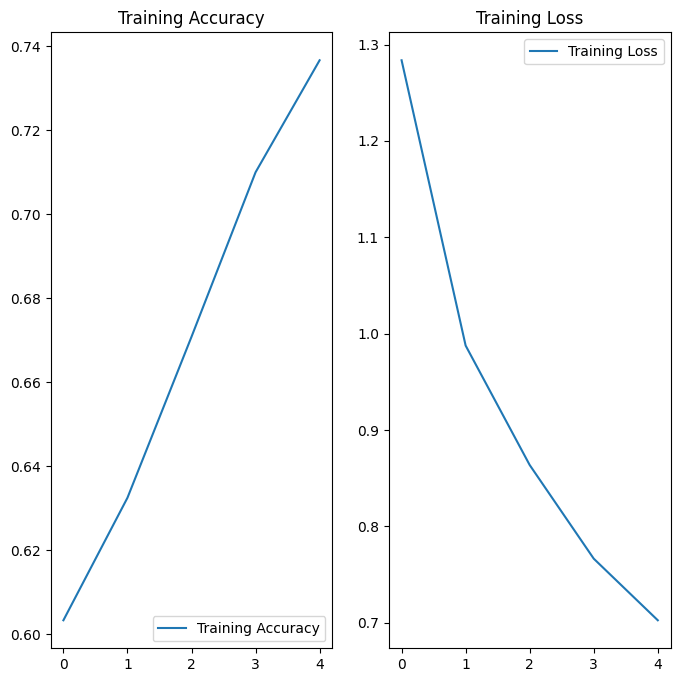

In [26]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [31]:
model.save("Output/gru_model_vidisha.h5")

In [32]:
model = tf.keras.models.load_model("Output/gru_model_vidisha.h5")

## Prediction

In [29]:
scores = model.evaluate(X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7028 - loss: 0.9491


In [30]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.00%
